# Support Vector Machine (SVM) for Flight Delay Prediction

This notebook implements Support Vector Machine (SVM) models for flight delay prediction using the preprocessed data created in the `02_ml_preprocessing.ipynb` pipeline. We'll use the standard ML-optimized dataset which includes properly scaled features and encoded categorical variables, which are essential for SVM performance.

## Objectives
1. Load the preprocessed data optimized for standard ML models
2. Explore and understand the key features
3. Implement SVM regression models for delay prediction
4. Tune hyperparameters for optimal performance
5. Evaluate model performance using relevant metrics
6. Perform feature importance analysis
7. Save the optimized model for deployment

Unlike tree-based models, SVMs are sensitive to feature scaling and work well with the standardized features provided by the standard ML preprocessing pipeline. However, they can struggle with very large datasets, so we'll implement strategies to handle the size of our flight data efficiently.

In [10]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVR, LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.pipeline import Pipeline
import joblib
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# Configure paths dynamically using relative paths
import os.path as path

# Get the directory of the current notebook
notebook_dir = path.dirname(path.abspath('__file__'))
# Get project root (parent of notebooks directory)
project_root = path.abspath(path.join(notebook_dir, '..', '..'))

# Define paths relative to project root
ML_PROCESSED_PATH = path.join(project_root, 'data', 'processed', 'ml_ready_flights', 'ml_ready_flights.csv')
MODELS_PATH = path.join(project_root, 'models', 'machine_learning')

# Create directories if they don't exist
os.makedirs(MODELS_PATH, exist_ok=True)

# Print paths for reference
print(f"ML-ready dataset path: {ML_PROCESSED_PATH}")
print(f"Models will be saved to: {MODELS_PATH}")

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
print("Libraries and paths configured.")

ML-ready dataset path: /Users/osx/DataSceince_FL_FR/Forecasting_Flights-DataScience/data/processed/ml_ready_flights/ml_ready_flights.csv
Models will be saved to: /Users/osx/DataSceince_FL_FR/Forecasting_Flights-DataScience/models/machine_learning
Libraries and paths configured.


In [11]:
# Function to load data in chunks to handle large datasets
def load_processed_data(file_path, chunk_size=100000, max_chunks=None):
    """
    Load preprocessed data in chunks and combine into a single DataFrame.
    For SVM models, we typically need to sample the data to make it manageable.
    
    Parameters:
    -----------
    file_path : str
        Path to the processed data file
    chunk_size : int
        Number of rows to read at once
    max_chunks : int or None
        Maximum number of chunks to read (useful for development/testing)
        If None, read all chunks
        
    Returns:
    --------
    pandas.DataFrame
        Combined DataFrame with all loaded data
    """
    chunks = []
    
    for i, chunk in enumerate(pd.read_csv(file_path, chunksize=chunk_size)):
        # Stop after max_chunks if specified
        if max_chunks is not None and i >= max_chunks:
            break
        
        # Convert date columns to datetime
        date_columns = [col for col in chunk.columns if 'DATE' in col.upper()]
        for col in date_columns:
            chunk[col] = pd.to_datetime(chunk[col], errors='coerce')
        
        chunks.append(chunk)
        print(f"Loaded chunk {i+1} with shape: {chunk.shape}")
    
    # Combine all chunks
    combined_data = pd.concat(chunks, ignore_index=True)
    
    return combined_data

In [12]:
# Load the ML-optimized data for SVM
# For SVMs, we need to be cautious about the data size, so we'll limit the chunks initially
ml_data = load_processed_data(ML_PROCESSED_PATH, max_chunks=1)

print(f"\nLoaded data shape: {ml_data.shape}")
print("\nColumns and data types:")
for col in ml_data.columns:
    print(f"- {col}: {ml_data[col].dtype}")

print("\nSample data (first 5 rows):")
display(ml_data.head())

Loaded chunk 1 with shape: (48946, 21)

Loaded data shape: (48946, 21)

Columns and data types:
- ARR_DELAY: float64
- DEP_DELAY_IS_OUTLIER: int64
- DELAY_DUE_CARRIER: float64
- DELAY_DUE_LATE_AIRCRAFT: float64
- DELAY_DUE_WEATHER: float64
- TAXI_OUT: float64
- DELAY_DUE_NAS: float64
- ARR_TIME: float64
- ELAPSED_TIME: float64
- WHEELS_ON: float64
- TAXI_IN: float64
- DOT_CODE: int64
- AIR_TIME: float64
- TIME_OF_DAY_Evening: float64
- MONTH_COS: float64
- CRS_DEP_TIME: int64
- DEP_HOUR: int64
- DEP_HOUR_SIN: float64
- TIME_OF_DAY_Morning: float64
- MONTH_DAY: float64
- DEP_DELAY: float64

Sample data (first 5 rows):


,ARR_DELAY,DEP_DELAY_IS_OUTLIER,DELAY_DUE_CARRIER,DELAY_DUE_LATE_AIRCRAFT,DELAY_DUE_WEATHER,TAXI_OUT,DELAY_DUE_NAS,ARR_TIME,ELAPSED_TIME,WHEELS_ON,TAXI_IN,DOT_CODE,AIR_TIME,TIME_OF_DAY_Evening,MONTH_COS,CRS_DEP_TIME,DEP_HOUR,DEP_HOUR_SIN,TIME_OF_DAY_Morning,MONTH_DAY,DEP_DELAY
0,63.0,0,25.0,1.0,0.0,12.0,37.0,1813.0,127.0,1809.0,4.0,19393,111.0,0.0,-0.500000,940,15,-0.707107,0.0,48.0,26.0
1,38.0,0,38.0,0.0,0.0,13.0,0.0,1908.0,140.0,1857.0,11.0,20416,116.0,0.0,-0.866025,1022,17,-0.965926,0.0,63.0,46.0
2,28.0,0,0.0,22.0,0.0,24.0,6.0,2257.0,75.0,2245.0,12.0,19805,39.0,1.0,0.500000,1280,21,-0.707107,0.0,4.0,22.0
3,15.0,0,0.0,0.0,0.0,9.0,15.0,1318.0,148.0,1244.0,19.0,20368,105.0,0.0,-1.000000,658,10,0.500000,1.0,59.0,0.0
4,23.0,0,23.0,0.0,0.0,19.0,0.0,1400.0,130.0,1356.0,4.0,19790,107.0,0.0,-0.866025,680,11,0.258819,1.0,53.0,30.0


## Data Exploration and Preparation for SVM

Let's explore the preprocessed data and prepare it for SVM modeling. Since SVMs don't scale well with large datasets, we need to:

1. Sample the data to a manageable size
2. Verify our features are properly scaled
3. Select the most relevant features 
4. Split the data into training and test sets

In [13]:
# Sample the data to a manageable size for SVM
# SVMs typically don't scale well to very large datasets
def prepare_svm_dataset(df, target_col='DEP_DELAY', sample_size=50000, random_state=42):
    """
    Prepare a dataset suitable for SVM modeling
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe
    target_col : str
        Target column name
    sample_size : int
        Size of the sample to use
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    tuple
        X_sample, y_sample (features and target)
    """
    # Sample the data if it's larger than sample_size
    if len(df) > sample_size:
        df_sample = df.sample(sample_size, random_state=random_state)
        print(f"Sampled {sample_size} rows from the original {len(df)} rows")
    else:
        df_sample = df
        print(f"Using all {len(df)} rows (less than requested sample size)")
    
    # Check for any string or object columns that might need encoding
    object_cols = df_sample.select_dtypes(include=['object', 'string']).columns.tolist()
    if object_cols:
        print(f"Warning: Found {len(object_cols)} non-numeric columns that may need encoding: {object_cols}")
        
        # Drop these columns for now as they should have been encoded in preprocessing
        df_sample = df_sample.drop(columns=object_cols)
        print(f"Dropped non-numeric columns. New shape: {df_sample.shape}")
    
    # Split features and target
    if target_col in df_sample.columns:
        X = df_sample.drop(columns=[target_col])
        y = df_sample[target_col]
    else:
        raise ValueError(f"Target column '{target_col}' not found in dataframe")
    
    # Verify no NaN values, which SVMs cannot handle
    if X.isnull().any().any():
        print("Warning: Found NaN values. Imputing with column means...")
        X = X.fillna(X.mean())
    
    if y.isnull().any():
        print("Warning: Found NaN values in target. Dropping those rows...")
        nan_indices = y.isnull()
        X = X.loc[~nan_indices]
        y = y.loc[~nan_indices]
    
    return X, y

# Prepare dataset for SVM modeling
X, y = prepare_svm_dataset(ml_data)

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

Using all 48946 rows (less than requested sample size)
Feature matrix shape: (48946, 20)
Target vector shape: (48946,)


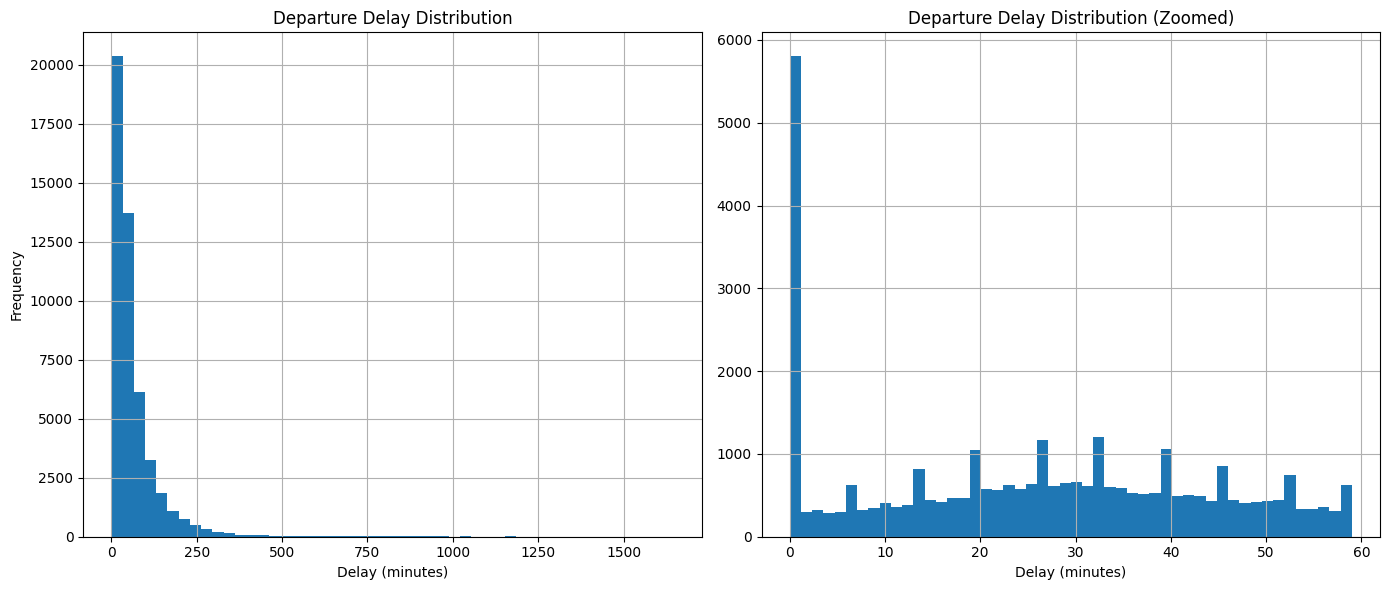


Statistics of DEP_DELAY:
count    48946.000000
mean        64.400237
std         94.580467
min          0.000000
25%         19.000000
50%         40.000000
75%         77.000000
max       1646.000000
Name: DEP_DELAY, dtype: float64

Flight status percentages:
Early departures: 0.00%
On-time departures: 11.07%
Delayed departures: 88.93%


In [14]:
# Explore the target variable distribution
plt.figure(figsize=(14, 6))

plt.subplot(121)
y.hist(bins=50)
plt.title('Departure Delay Distribution')
plt.xlabel('Delay (minutes)')
plt.ylabel('Frequency')

plt.subplot(122)
# Zoom in on the central part of the distribution (exclude extreme values)
delay_zoomed = y[(y > -30) & (y < 60)]
delay_zoomed.hist(bins=50)
plt.title('Departure Delay Distribution (Zoomed)')
plt.xlabel('Delay (minutes)')

plt.tight_layout()
plt.show()

# Basic statistics of the target variable
print("\nStatistics of DEP_DELAY:")
print(y.describe())

# Calculate percentage of negative delays (early departures) and positive delays
early_pct = (y < 0).mean() * 100
on_time_pct = (y == 0).mean() * 100
delayed_pct = (y > 0).mean() * 100

print(f"\nFlight status percentages:")
print(f"Early departures: {early_pct:.2f}%")
print(f"On-time departures: {on_time_pct:.2f}%")
print(f"Delayed departures: {delayed_pct:.2f}%")


Top 15 features correlated with DEP_DELAY:
ARR_DELAY                  0.717325
DEP_DELAY_IS_OUTLIER       0.711616
DELAY_DUE_CARRIER          0.688659
DELAY_DUE_LATE_AIRCRAFT    0.536783
DELAY_DUE_WEATHER          0.278364
TAXI_OUT                   0.124210
DELAY_DUE_NAS              0.090992
ARR_TIME                   0.082987
WHEELS_ON                  0.077118
ELAPSED_TIME               0.069591
DOT_CODE                   0.063375
TAXI_IN                    0.053469
AIR_TIME                   0.037743
TIME_OF_DAY_Evening        0.034284
TIME_OF_DAY_Morning        0.031281
dtype: float64


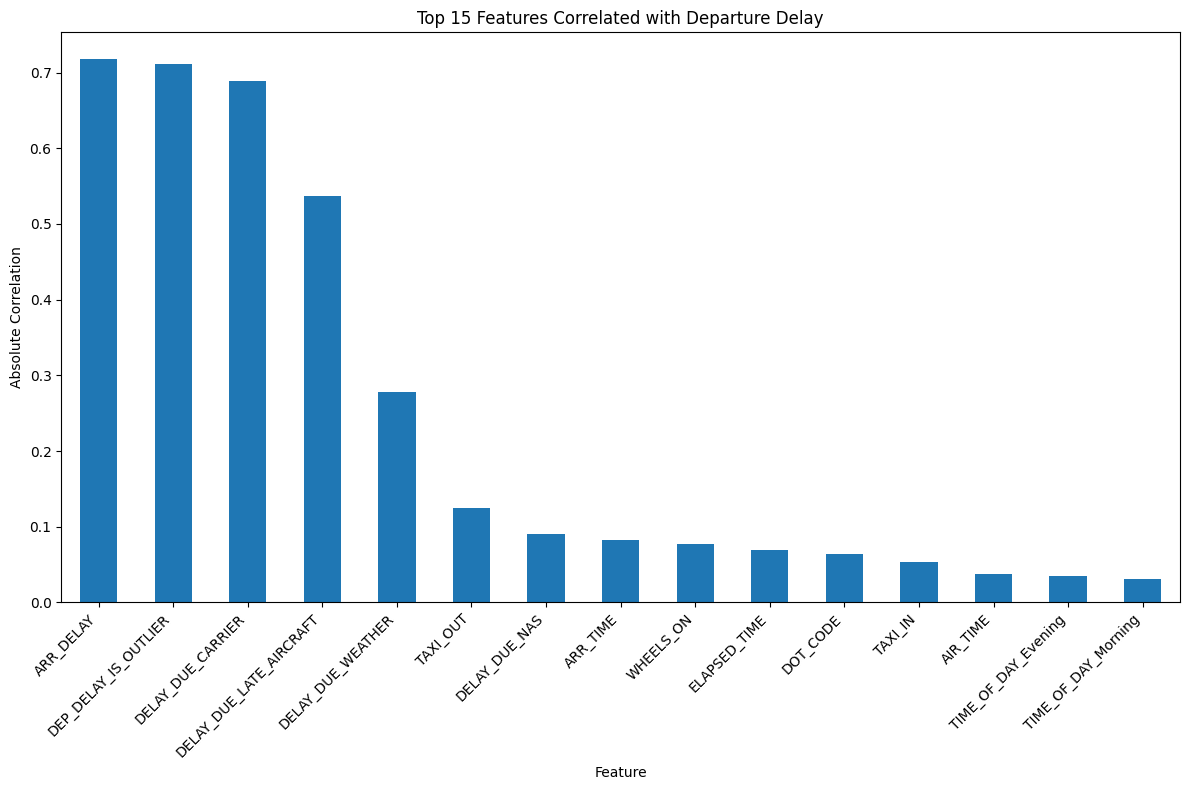


Feature ranges (checking if already scaled):
                          min     max         mean         std
ARR_DELAY                 0.0   159.0    56.859672   43.276091
DEP_DELAY_IS_OUTLIER      0.0     1.0     0.074797    0.263066
DELAY_DUE_CARRIER         0.0  1646.0    24.535972   70.727546
DELAY_DUE_LATE_AIRCRAFT   0.0  1332.0    26.228173   55.803245
DELAY_DUE_WEATHER         0.0  1459.0     3.828508   31.079939
TAXI_OUT                  1.0    44.5    20.141166   10.684639
DELAY_DUE_NAS             0.0  1153.0    12.965121   30.567895
ARR_TIME                  1.0  2400.0  1545.083704  639.859043
ELAPSED_TIME             23.0   720.0   151.119581   75.997442
WHEELS_ON                 1.0  2400.0  1550.114473  627.294479

Features are on different scales, scaling will be applied


In [15]:
# Check feature correlations with the target
correlations = X.corrwith(y).abs().sort_values(ascending=False)

print("\nTop 15 features correlated with DEP_DELAY:")
print(correlations.head(15))

# Visualize the top correlated features
plt.figure(figsize=(12, 8))
correlations.head(15).plot(kind='bar')
plt.title('Top 15 Features Correlated with Departure Delay')
plt.xlabel('Feature')
plt.ylabel('Absolute Correlation')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Verify if data is already scaled
feature_ranges = pd.DataFrame({
    'min': X.min(),
    'max': X.max(),
    'mean': X.mean(),
    'std': X.std()
})

print("\nFeature ranges (checking if already scaled):")
print(feature_ranges.head(10))

# Check if features are on different scales (which would require scaling)
needs_scaling = (feature_ranges['max'] - feature_ranges['min'] > 10).any()
if needs_scaling:
    print("\nFeatures are on different scales, scaling will be applied")
else:
    print("\nFeatures appear to be already scaled")

In [16]:
# Split data into train and test sets (time-based would be ideal, but for simplicity using random split)
def split_data_for_svm(X, y, test_size=0.2, random_state=42):
    """
    Split the data into train and test sets
    
    Parameters:
    -----------
    X, y : Features and target
    test_size : float
        Proportion of data to use for testing
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    tuple
        X_train, X_test, y_train, y_test
    """
    # Check if X has a date column for time-based splitting
    date_cols = [col for col in X.columns if 'DATE' in col.upper() or 'TIME' in col.upper()]
    
    if date_cols and 'FL_DATE' in X.columns:
        print("Using time-based splitting...")
        # Sort by date
        sorted_indices = X['FL_DATE'].argsort()
        X_sorted = X.iloc[sorted_indices]
        y_sorted = y.iloc[sorted_indices]
        
        # Split based on time
        test_start_idx = int(len(X) * (1 - test_size))
        X_train, X_test = X_sorted.iloc[:test_start_idx], X_sorted.iloc[test_start_idx:]
        y_train, y_test = y_sorted.iloc[:test_start_idx], y_sorted.iloc[test_start_idx:]
        
        # Drop the date column for modeling
        if 'FL_DATE' in X_train.columns:
            X_train = X_train.drop(columns=['FL_DATE'])
            X_test = X_test.drop(columns=['FL_DATE'])
            
        print(f"Train period: from {X_sorted['FL_DATE'].iloc[0]} to {X_sorted['FL_DATE'].iloc[test_start_idx-1]}")
        print(f"Test period: from {X_sorted['FL_DATE'].iloc[test_start_idx]} to {X_sorted['FL_DATE'].iloc[-1]}")
    else:
        print("Using random splitting (no date column for time-based split)...")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    print(f"Train set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
    print(f"Test set: {X_test.shape[0]} samples, {X_test.shape[1]} features")
    
    return X_train, X_test, y_train, y_test

# Split the data
X_train, X_test, y_train, y_test = split_data_for_svm(X, y)

Using random splitting (no date column for time-based split)...
Train set: 39156 samples, 20 features
Test set: 9790 samples, 20 features


In [17]:
# Feature selection for SVM
def select_features_for_svm(X_train, y_train, X_test, k=20):
    """
    Select features for SVM using SelectKBest
    
    Parameters:
    -----------
    X_train, y_train : Training data
    X_test : Test features
    k : int
        Number of features to select
        
    Returns:
    --------
    tuple
        X_train_selected, X_test_selected, selected_features
    """
    # Use SelectKBest to select features based on correlation with target
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    # Get the selected features
    selected_mask = selector.get_support()
    selected_features = X_train.columns[selected_mask].tolist()
    
    print(f"Selected {len(selected_features)} features")
    print(f"Top 10 selected features: {selected_features[:10]}")
    
    # Convert to DataFrame for easier handling
    X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features)
    X_test_selected = pd.DataFrame(X_test_selected, columns=selected_features)
    
    return X_train_selected, X_test_selected, selected_features

# Select features
X_train_selected, X_test_selected, selected_features = select_features_for_svm(X_train, y_train, X_test, k=min(20, X_train.shape[1]))

Selected 20 features
Top 10 selected features: ['ARR_DELAY', 'DEP_DELAY_IS_OUTLIER', 'DELAY_DUE_CARRIER', 'DELAY_DUE_LATE_AIRCRAFT', 'DELAY_DUE_WEATHER', 'TAXI_OUT', 'DELAY_DUE_NAS', 'ARR_TIME', 'ELAPSED_TIME', 'WHEELS_ON']


## Linear SVM Implementation

We'll start with a Linear SVM which is more efficient for large datasets. LinearSVR is a good starting point as it scales better to the size of our dataset compared to standard SVR with non-linear kernels.

In [18]:
# Train a simple LinearSVR model first
def train_linear_svm(X_train, y_train, X_test, y_test):
    """
    Train a LinearSVR model and evaluate performance
    
    Parameters:
    -----------
    X_train, y_train : Training data
    X_test, y_test : Test data
    
    Returns:
    --------
    tuple
        Trained model, test predictions, evaluation metrics
    """
    print("Training LinearSVR model...")
    
    # Create a pipeline with scaling and LinearSVR
    # Even if data is already scaled, it's a good practice to ensure it's properly scaled for SVMs
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', LinearSVR(
            epsilon=0.5,          # The epsilon parameter in the epsilon-insensitive loss function
            C=1.0,                # Regularization parameter
            max_iter=1000,        # Increase if needed for convergence
            tol=1e-4,             # Tolerance for stopping criterion
            random_state=42,      # For reproducibility
            dual=True,            # Setting to True for compatibility with epsilon_insensitive loss
            loss='epsilon_insensitive'  # Explicitly setting the loss function
        ))
    ])
    
    # Start timing the training process
    start_time = datetime.now()
    
    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # End timing
    end_time = datetime.now()
    training_time = (end_time - start_time).total_seconds()
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Make predictions on test data
    y_pred = pipeline.predict(X_test)
    
    # Evaluate performance
    metrics = {
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'mae': mean_absolute_error(y_test, y_pred),
        'r2': r2_score(y_test, y_pred),
        'explained_variance': explained_variance_score(y_test, y_pred)
    }
    
    print("\nLinearSVR Model Performance:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name.upper()}: {metric_value:.4f}")
    
    return pipeline, y_pred, metrics

# Train the linear SVM
linear_svm, y_pred_linear, linear_metrics = train_linear_svm(X_train_selected, y_train, X_test_selected, y_test)

Training LinearSVR model...
Training completed in 0.63 seconds

LinearSVR Model Performance:
RMSE: 15.8487
MAE: 9.1606
R2: 0.9752
EXPLAINED_VARIANCE: 0.9754


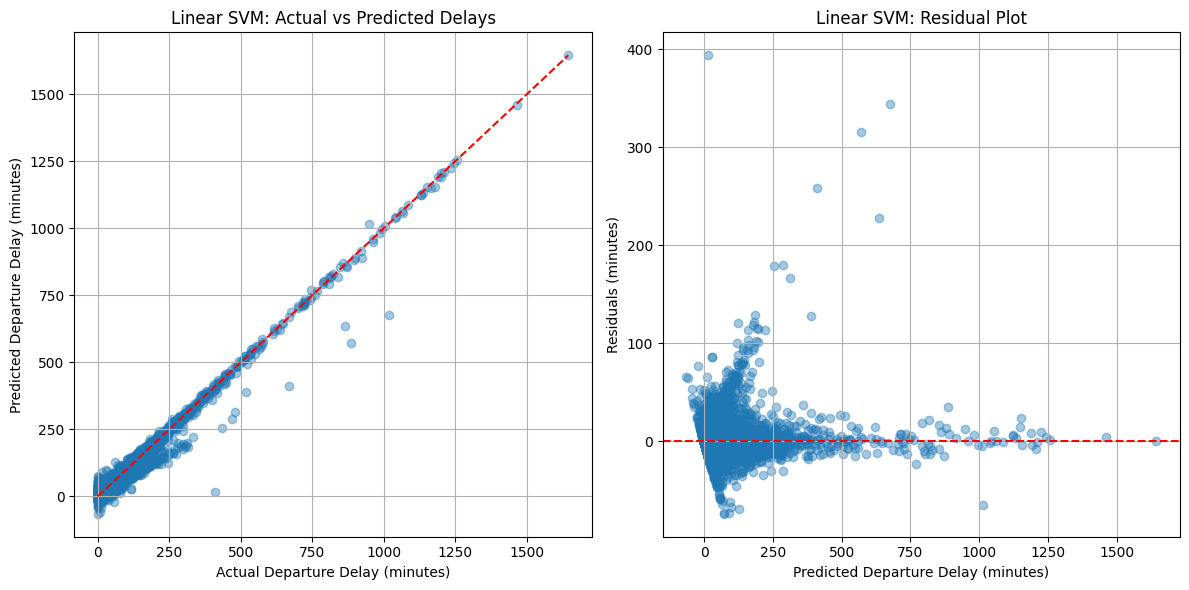

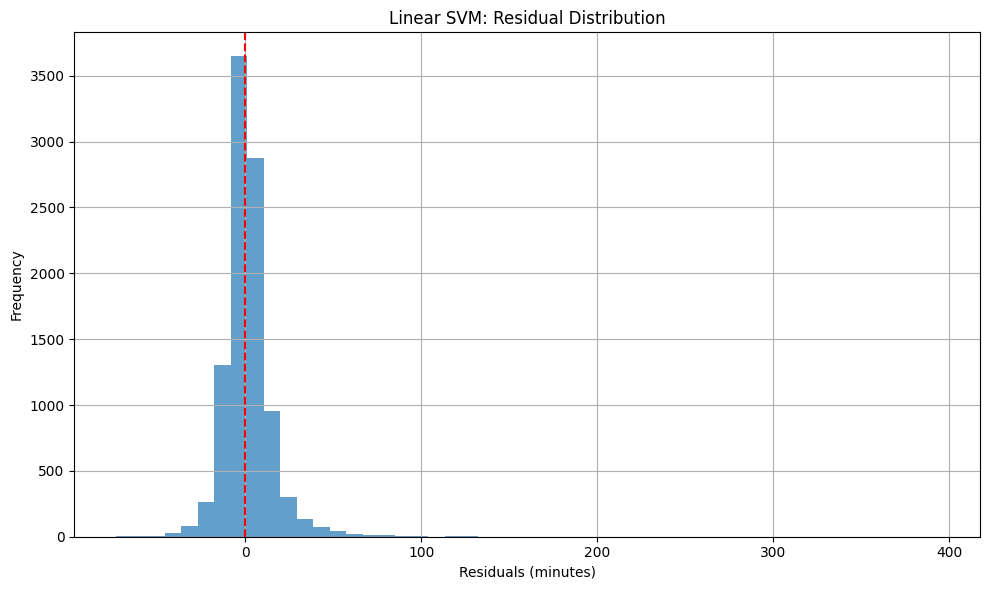

In [19]:
# Visualize the linear SVM predictions
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.scatter(y_test, y_pred_linear, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Departure Delay (minutes)')
plt.ylabel('Predicted Departure Delay (minutes)')
plt.title('Linear SVM: Actual vs Predicted Delays')
plt.grid(True)

plt.subplot(122)
residuals = y_test - y_pred_linear
plt.scatter(y_pred_linear, residuals, alpha=0.4)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Departure Delay (minutes)')
plt.ylabel('Residuals (minutes)')
plt.title('Linear SVM: Residual Plot')
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot residuals histogram
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Residuals (minutes)')
plt.ylabel('Frequency')
plt.title('Linear SVM: Residual Distribution')
plt.grid(True)
plt.tight_layout()
plt.show()

## SVM with Non-Linear Kernel

Next, we'll implement an SVM with a non-linear kernel (RBF) which can capture more complex patterns in the data. However, this is more computationally expensive, so we'll use a smaller subset of the data if needed.

In [20]:
# Sample down further if needed for non-linear SVM
def prepare_data_for_nonlinear_svm(X_train, y_train, max_samples=10000, random_state=42):
    """
    Prepare a smaller dataset for non-linear SVM if needed
    
    Parameters:
    -----------
    X_train, y_train : Training data
    max_samples : int
        Maximum number of samples to use
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    tuple
        X_train_small, y_train_small
    """
    if len(X_train) > max_samples:
        print(f"Sampling {max_samples} records for non-linear SVM training...")
        # Sample to reduce computational load
        indices = np.random.RandomState(random_state).choice(
            len(X_train), size=max_samples, replace=False
        )
        X_train_small = X_train.iloc[indices]
        y_train_small = y_train.iloc[indices]
        print(f"Sampled dataset shape: {X_train_small.shape}")
    else:
        X_train_small = X_train
        y_train_small = y_train
        print(f"Using full training set: {X_train_small.shape}")
    
    return X_train_small, y_train_small

# Prepare smaller dataset for non-linear SVM
X_train_small, y_train_small = prepare_data_for_nonlinear_svm(X_train_selected, y_train)

Sampling 10000 records for non-linear SVM training...
Sampled dataset shape: (10000, 20)


In [21]:
# Train a non-linear SVM with RBF kernel
def train_nonlinear_svm(X_train, y_train, X_test, y_test):
    """
    Train a non-linear SVR model with RBF kernel and evaluate performance
    
    Parameters:
    -----------
    X_train, y_train : Training data
    X_test, y_test : Test data
    
    Returns:
    --------
    tuple
        Trained model, test predictions, evaluation metrics
    """
    print("Training non-linear SVR model with RBF kernel...")
    
    # Create a pipeline with scaling and SVR with RBF kernel
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVR(
            kernel='rbf',         # Radial Basis Function kernel
            epsilon=0.5,          # Epsilon-tube parameter
            C=100.0,              # Regularization parameter (higher values reduce regularization)
            gamma='scale',        # Kernel coefficient
            cache_size=1000,      # Cache size in MB for faster training
            max_iter=-1,          # No limit on iterations
            tol=1e-3              # Tolerance for stopping criterion
        ))
    ])
    
    # Start timing the training process
    start_time = datetime.now()
    
    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # End timing
    end_time = datetime.now()
    training_time = (end_time - start_time).total_seconds()
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Make predictions on test data
    y_pred = pipeline.predict(X_test)
    
    # Evaluate performance
    metrics = {
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'mae': mean_absolute_error(y_test, y_pred),
        'r2': r2_score(y_test, y_pred),
        'explained_variance': explained_variance_score(y_test, y_pred)
    }
    
    print("\nNon-linear SVR Model Performance:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name.upper()}: {metric_value:.4f}")
    
    return pipeline, y_pred, metrics

# Train the non-linear SVM
nonlinear_svm, y_pred_nonlinear, nonlinear_metrics = train_nonlinear_svm(X_train_small, y_train_small, X_test_selected, y_test)

Training non-linear SVR model with RBF kernel...
Training completed in 7.97 seconds

Non-linear SVR Model Performance:
RMSE: 43.8119
MAE: 9.6309
R2: 0.8102
EXPLAINED_VARIANCE: 0.8117


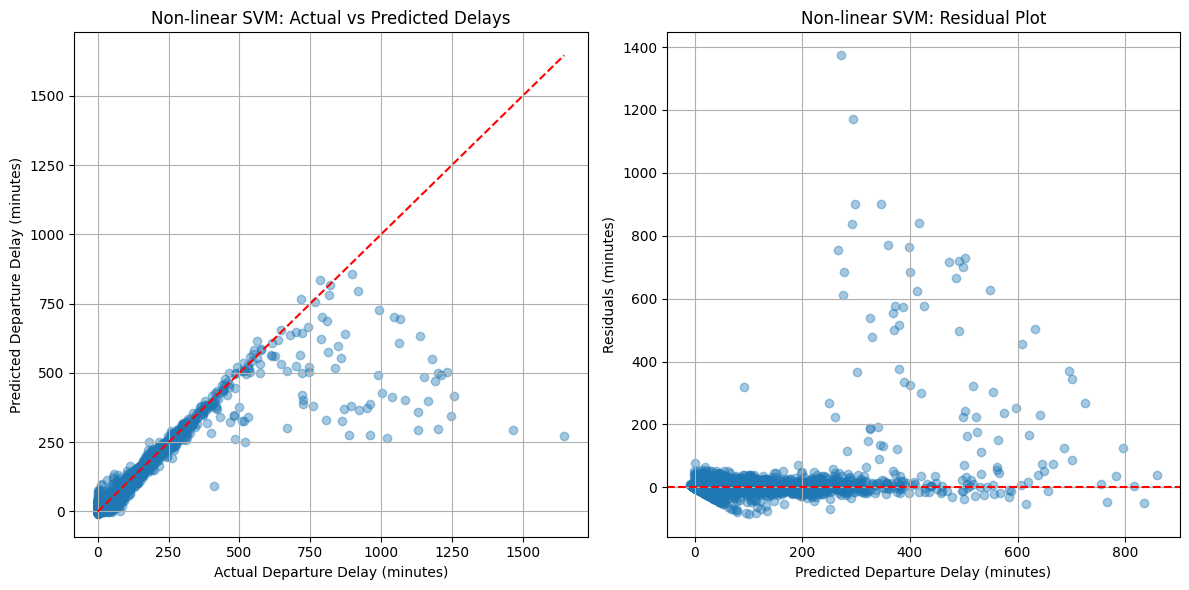

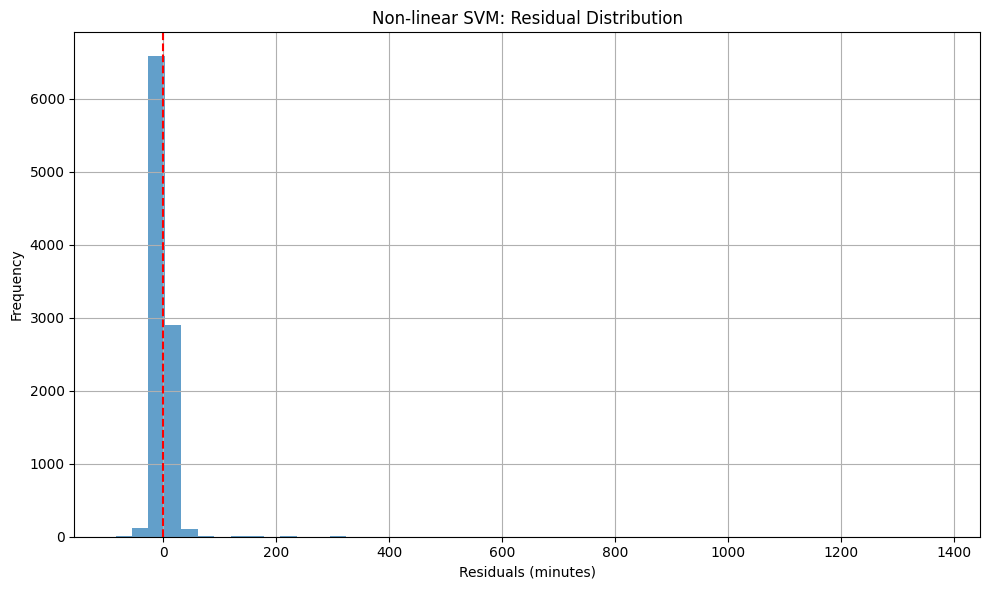

In [22]:
# Visualize the non-linear SVM predictions
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.scatter(y_test, y_pred_nonlinear, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Departure Delay (minutes)')
plt.ylabel('Predicted Departure Delay (minutes)')
plt.title('Non-linear SVM: Actual vs Predicted Delays')
plt.grid(True)

plt.subplot(122)
residuals = y_test - y_pred_nonlinear
plt.scatter(y_pred_nonlinear, residuals, alpha=0.4)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Departure Delay (minutes)')
plt.ylabel('Residuals (minutes)')
plt.title('Non-linear SVM: Residual Plot')
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot residuals histogram
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Residuals (minutes)')
plt.ylabel('Frequency')
plt.title('Non-linear SVM: Residual Distribution')
plt.grid(True)
plt.tight_layout()
plt.show()

## Hyperparameter Tuning for SVM

We'll use grid search to tune the hyperparameters of the SVM models. Due to the computational requirements, we'll use a small subset of data for tuning.

In [23]:
# Create a smaller dataset for hyperparameter tuning
X_tune, y_tune = prepare_data_for_nonlinear_svm(X_train_selected, y_train, max_samples=5000)

# Hyperparameter tuning for LinearSVR
def tune_linear_svm(X_tune, y_tune):
    """
    Tune hyperparameters for LinearSVR
    
    Parameters:
    -----------
    X_tune, y_tune : Tuning data
    
    Returns:
    --------
    dict
        Best parameters
    """
    print("Tuning LinearSVR hyperparameters...")
    
    # Create a pipeline with scaling and LinearSVR
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', LinearSVR(max_iter=2000, random_state=42, dual=False))
    ])
    
    # Define parameter grid
    param_grid = {
        'svm__C': [0.1, 1.0, 10.0, 100.0],
        'svm__epsilon': [0.1, 0.5, 1.0],
        'svm__loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']
    }
    
    # Use RandomizedSearchCV to save time
    search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_grid,
        n_iter=10,
        cv=3,
        scoring='neg_mean_squared_error',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    
    # Start timing
    start_time = datetime.now()
    
    # Fit the search
    search.fit(X_tune, y_tune)
    
    # End timing
    end_time = datetime.now()
    tuning_time = (end_time - start_time).total_seconds()
    print(f"Tuning completed in {tuning_time:.2f} seconds")
    
    # Print results
    print(f"Best parameters: {search.best_params_}")
    print(f"Best RMSE: {np.sqrt(-search.best_score_):.4f}")
    
    return search.best_params_

# Hyperparameter tuning for non-linear SVR
def tune_nonlinear_svm(X_tune, y_tune):
    """
    Tune hyperparameters for non-linear SVR
    
    Parameters:
    -----------
    X_tune, y_tune : Tuning data
    
    Returns:
    --------
    dict
        Best parameters
    """
    print("Tuning non-linear SVR hyperparameters...")
    
    # Create a pipeline with scaling and SVR
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVR(cache_size=1000, max_iter=2000))
    ])
    
    # Define parameter grid
    param_grid = {
        'svm__C': [1.0, 10.0, 100.0],
        'svm__epsilon': [0.1, 0.5, 1.0],
        'svm__gamma': ['scale', 'auto', 0.01, 0.1]
    }
    
    # Use RandomizedSearchCV to save time
    search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_grid,
        n_iter=8,
        cv=3,
        scoring='neg_mean_squared_error',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    
    # Start timing
    start_time = datetime.now()
    
    # Fit the search
    search.fit(X_tune, y_tune)
    
    # End timing
    end_time = datetime.now()
    tuning_time = (end_time - start_time).total_seconds()
    print(f"Tuning completed in {tuning_time:.2f} seconds")
    
    # Print results
    print(f"Best parameters: {search.best_params_}")
    print(f"Best RMSE: {np.sqrt(-search.best_score_):.4f}")
    
    return search.best_params_

# Tune the models
linear_best_params = tune_linear_svm(X_tune, y_tune)
nonlinear_best_params = tune_nonlinear_svm(X_tune, y_tune)

Sampling 5000 records for non-linear SVM training...
Sampled dataset shape: (5000, 20)
Tuning LinearSVR hyperparameters...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Tuning completed in 3.60 seconds
Best parameters: {'svm__loss': 'squared_epsilon_insensitive', 'svm__epsilon': 0.5, 'svm__C': 1.0}
Best RMSE: 13.8145
Tuning non-linear SVR hyperparameters...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Tuning completed in 3.60 seconds
Best parameters: {'svm__loss': 'squared_epsilon_insensitive', 'svm__epsilon': 0.5, 'svm__C': 1.0}
Best RMSE: 13.8145
Tuning non-linear SVR hyperparameters...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/Users/osx/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/osx/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/osx/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/osx/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/osx/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarn

Tuning completed in 8.25 seconds
Best parameters: {'svm__gamma': 0.01, 'svm__epsilon': 0.5, 'svm__C': 100.0}
Best RMSE: 27.3767


In [24]:
# Train final models with best parameters
def train_final_linear_svm(X_train, y_train, best_params):
    """
    Train the final LinearSVR model with best parameters
    
    Parameters:
    -----------
    X_train, y_train : Training data
    best_params : dict
        Best hyperparameters
    
    Returns:
    --------
    Pipeline
        Trained pipeline
    """
    print("Training final LinearSVR model with tuned parameters...")
    
    # Extract parameters
    C = best_params.get('svm__C', 1.0)
    epsilon = best_params.get('svm__epsilon', 0.5)
    loss = best_params.get('svm__loss', 'epsilon_insensitive')
    
    # Create a pipeline with scaling and LinearSVR
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', LinearSVR(
            C=C, 
            epsilon=epsilon,
            loss=loss,
            max_iter=2000,
            random_state=42,
            dual=False
        ))
    ])
    
    # Start timing
    start_time = datetime.now()
    
    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # End timing
    end_time = datetime.now()
    training_time = (end_time - start_time).total_seconds()
    print(f"Training completed in {training_time:.2f} seconds")
    
    return pipeline

def train_final_nonlinear_svm(X_train, y_train, best_params):
    """
    Train the final non-linear SVR model with best parameters
    
    Parameters:
    -----------
    X_train, y_train : Training data
    best_params : dict
        Best hyperparameters
    
    Returns:
    --------
    Pipeline
        Trained pipeline
    """
    print("Training final non-linear SVR model with tuned parameters...")
    
    # Extract parameters
    C = best_params.get('svm__C', 100.0)
    epsilon = best_params.get('svm__epsilon', 0.5)
    gamma = best_params.get('svm__gamma', 'scale')
    
    # Create a pipeline with scaling and SVR
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVR(
            kernel='rbf',
            C=C, 
            epsilon=epsilon,
            gamma=gamma,
            cache_size=1000,
            max_iter=2000
        ))
    ])
    
    # Start timing
    start_time = datetime.now()
    
    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # End timing
    end_time = datetime.now()
    training_time = (end_time - start_time).total_seconds()
    print(f"Training completed in {training_time:.2f} seconds")
    
    return pipeline

# Train final LinearSVR model
final_linear_svm = train_final_linear_svm(X_train_selected, y_train, linear_best_params)

# For the non-linear model, use the smaller dataset if it's very large
final_nonlinear_svm = train_final_nonlinear_svm(X_train_small, y_train_small, nonlinear_best_params)

Training final LinearSVR model with tuned parameters...
Training completed in 0.17 seconds
Training final non-linear SVR model with tuned parameters...
Training completed in 3.06 seconds



Model Performance Comparison:
               Model      RMSE       MAE       R²  Explained Variance
          Linear SVM 13.815496  9.282398 0.981131            0.981133
Non-linear SVM (RBF) 23.963175 11.757249 0.943232            0.951081


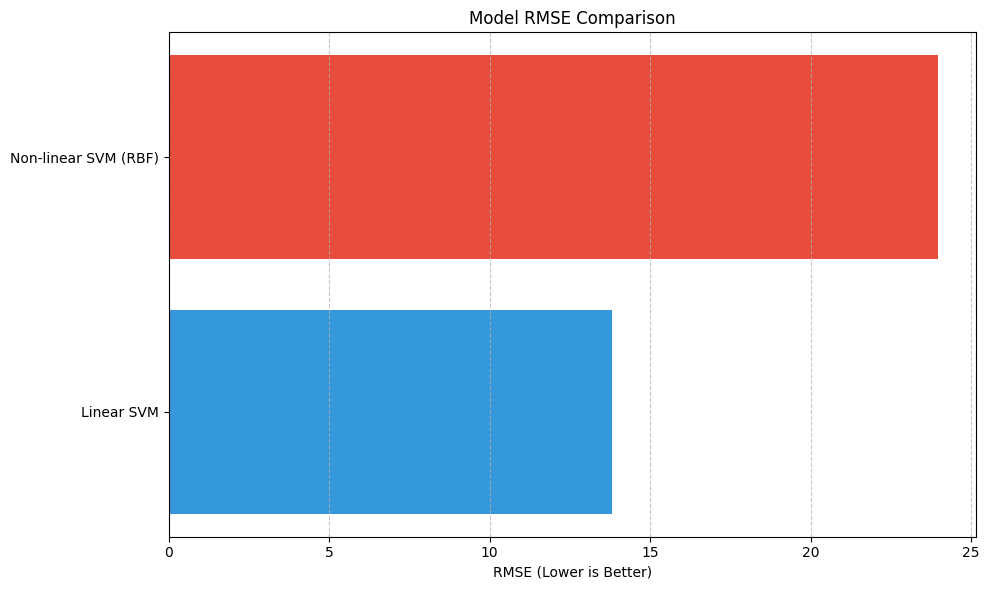

In [25]:
# Evaluate the final models
def evaluate_svm_models(models, X_test, y_test, model_names):
    """
    Evaluate multiple SVM models and compare
    
    Parameters:
    -----------
    models : list
        List of trained models
    X_test : Test features
    y_test : Test target
    model_names : list
        List of model names
    
    Returns:
    --------
    dict
        Dictionary of predictions
    """
    # Make predictions
    predictions = {}
    metrics_table = []
    
    for model, name in zip(models, model_names):
        # Predict
        y_pred = model.predict(X_test)
        predictions[name] = y_pred
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        explained_var = explained_variance_score(y_test, y_pred)
        
        metrics_table.append({
            'Model': name,
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2,
            'Explained Variance': explained_var
        })
    
    # Display metrics as a table
    metrics_df = pd.DataFrame(metrics_table)
    print("\nModel Performance Comparison:")
    print(metrics_df.to_string(index=False))
    
    # Create bar plot of RMSE for comparison
    plt.figure(figsize=(10, 6))
    plt.barh(metrics_df['Model'], metrics_df['RMSE'], color=['#3498db', '#e74c3c'])
    plt.xlabel('RMSE (Lower is Better)')
    plt.title('Model RMSE Comparison')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    return predictions

# Evaluate the models
predictions = evaluate_svm_models(
    [final_linear_svm, final_nonlinear_svm],
    X_test_selected,
    y_test,
    ['Linear SVM', 'Non-linear SVM (RBF)']
)

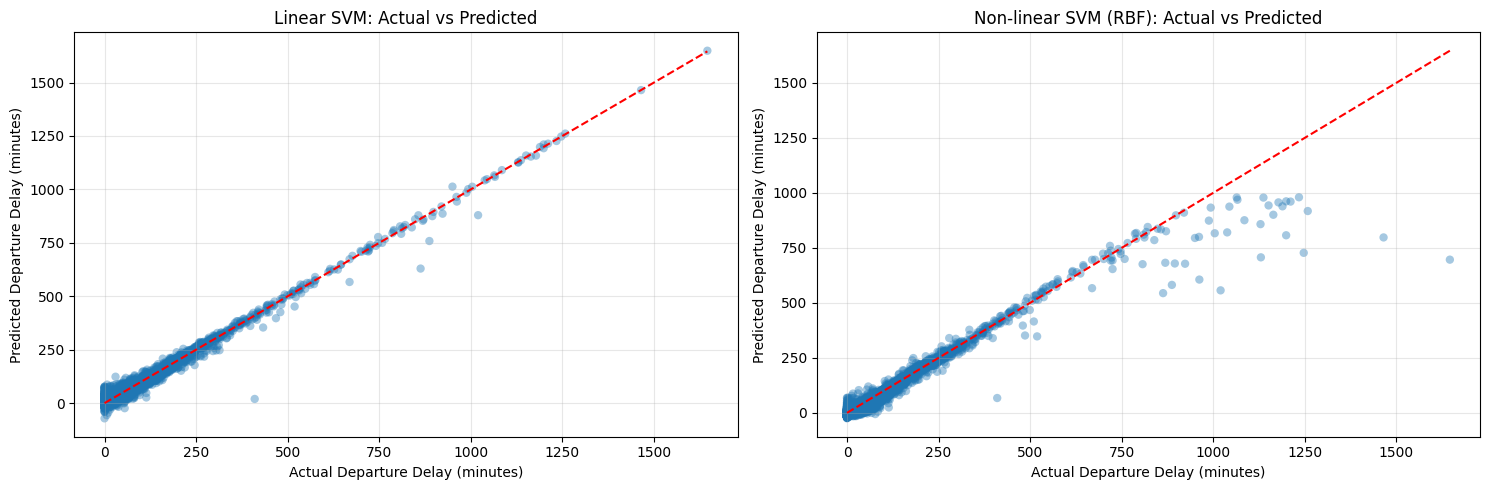

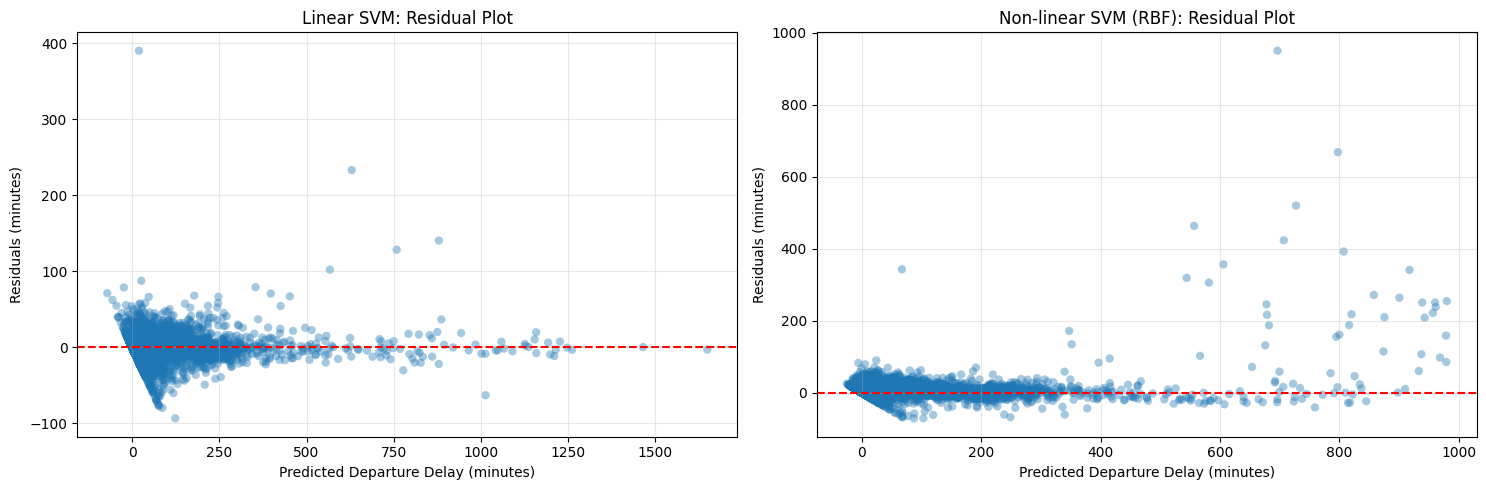

In [26]:
# Compare predictions for both models
def plot_prediction_comparison(y_test, predictions, model_names):
    """
    Plot side-by-side comparison of model predictions
    
    Parameters:
    -----------
    y_test : True target values
    predictions : dict
        Dictionary of predictions for each model
    model_names : list
        List of model names
    """
    n_models = len(model_names)
    
    # Create a figure with subplots for each model
    fig, axes = plt.subplots(1, n_models, figsize=(15, 5))
    
    for i, name in enumerate(model_names):
        ax = axes[i]
        y_pred = predictions[name]
        
        # Plot actual vs predicted
        ax.scatter(y_test, y_pred, alpha=0.4, edgecolors='none')
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        ax.set_xlabel('Actual Departure Delay (minutes)')
        ax.set_ylabel('Predicted Departure Delay (minutes)')
        ax.set_title(f'{name}: Actual vs Predicted')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Create a figure with residual plots
    fig, axes = plt.subplots(1, n_models, figsize=(15, 5))
    
    for i, name in enumerate(model_names):
        ax = axes[i]
        y_pred = predictions[name]
        residuals = y_test - y_pred
        
        # Plot residuals
        ax.scatter(y_pred, residuals, alpha=0.4, edgecolors='none')
        ax.axhline(y=0, color='r', linestyle='--')
        ax.set_xlabel('Predicted Departure Delay (minutes)')
        ax.set_ylabel('Residuals (minutes)')
        ax.set_title(f'{name}: Residual Plot')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot prediction comparisons
plot_prediction_comparison(
    y_test,
    predictions,
    ['Linear SVM', 'Non-linear SVM (RBF)']
)

In [27]:
# Save the models
def save_svm_models(models, model_names, selected_features, metrics):
    """
    Save trained SVM models and metadata
    
    Parameters:
    -----------
    models : list
        List of trained models
    model_names : list
        List of model names
    selected_features : list
        List of selected feature names
    metrics : pandas.DataFrame
        DataFrame of model metrics
    """
    # Create directory if it doesn't exist
    os.makedirs(MODELS_PATH, exist_ok=True)
    
    # Save each model
    for model, name in zip(models, model_names):
        # Format the name for the filename
        filename = name.lower().replace(' ', '_').replace('(', '').replace(')', '')
        model_path = os.path.join(MODELS_PATH, f'svm_{filename}_flight_delay_model.pkl')
        
        # Save the model
        joblib.dump(model, model_path)
        print(f"Saved {name} model to {model_path}")
    
    # Save feature list
    features_path = os.path.join(MODELS_PATH, 'svm_selected_features.json')
    with open(features_path, 'w') as f:
        json.dump(selected_features, f)
    print(f"Saved selected features to {features_path}")
    
    # Save metrics
    metrics_path = os.path.join(MODELS_PATH, 'svm_model_metrics.csv')
    metrics.to_csv(metrics_path, index=False)
    print(f"Saved model metrics to {metrics_path}")
    
    # Create a metadata file
    metadata = {
        'models': {name: f'svm_{name.lower().replace(" ", "_").replace("(", "").replace(")", "")}_flight_delay_model.pkl' 
                  for name in model_names},
        'features': selected_features,
        'performance_metrics': metrics.to_dict(orient='records'),
        'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'preprocessing': 'Standard ML preprocessing pipeline (not GB-optimized)'
    }
    
    metadata_path = os.path.join(MODELS_PATH, 'svm_model_metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"Saved model metadata to {metadata_path}")

# Create metrics dataframe
metrics_list = []
for name in ['Linear SVM', 'Non-linear SVM (RBF)']:
    y_pred = predictions[name]
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    explained_var = explained_variance_score(y_test, y_pred)
    
    metrics_list.append({
        'Model': name,
        'RMSE': float(rmse),
        'MAE': float(mae),
        'R2': float(r2),
        'Explained_Variance': float(explained_var)
    })

metrics_df = pd.DataFrame(metrics_list)

# Save the models
save_svm_models(
    [final_linear_svm, final_nonlinear_svm],
    ['Linear SVM', 'Non-linear SVM (RBF)'],
    selected_features,
    metrics_df
)

Saved Linear SVM model to /Users/osx/DataSceince_FL_FR/Forecasting_Flights-DataScience/models/machine_learning/svm_linear_svm_flight_delay_model.pkl
Saved Non-linear SVM (RBF) model to /Users/osx/DataSceince_FL_FR/Forecasting_Flights-DataScience/models/machine_learning/svm_non-linear_svm_rbf_flight_delay_model.pkl
Saved selected features to /Users/osx/DataSceince_FL_FR/Forecasting_Flights-DataScience/models/machine_learning/svm_selected_features.json
Saved model metrics to /Users/osx/DataSceince_FL_FR/Forecasting_Flights-DataScience/models/machine_learning/svm_model_metrics.csv
Saved model metadata to /Users/osx/DataSceince_FL_FR/Forecasting_Flights-DataScience/models/machine_learning/svm_model_metadata.json


In [28]:
# Create a prediction function for deployment
def predict_flight_delay_svm(flight_data, model_path, feature_path):
    """
    Make flight delay predictions using the SVM model
    
    Parameters:
    -----------
    flight_data : pandas.DataFrame
        Flight data in the same format as the training data
    model_path : str
        Path to the saved model
    feature_path : str
        Path to the saved feature list
        
    Returns:
    --------
    numpy.ndarray
        Predicted delays
    """
    # Load the model
    model = joblib.load(model_path)
    
    # Load selected features
    with open(feature_path, 'r') as f:
        selected_features = json.load(f)
    
    # Select only the required features
    available_features = [f for f in selected_features if f in flight_data.columns]
    
    if len(available_features) < len(selected_features):
        missing = set(selected_features) - set(available_features)
        print(f"Warning: Missing features: {missing}")
    
    X = flight_data[available_features]
    
    # Handle missing values
    if X.isnull().any().any():
        print("Warning: Handling missing values...")
        X = X.fillna(X.mean())
    
    # Make predictions
    predictions = model.predict(X)
    
    return predictions

# Test the prediction function on a small sample
sample_flights = X_test_selected.head(5)

# Path to the saved model
linear_model_path = os.path.join(MODELS_PATH, 'svm_linear_svm_flight_delay_model.pkl')
feature_path = os.path.join(MODELS_PATH, 'svm_selected_features.json')

# Test predictions
sample_predictions = predict_flight_delay_svm(sample_flights, linear_model_path, feature_path)

print("Sample Flight Delay Predictions:")
for i, pred in enumerate(sample_predictions):
    print(f"Flight {i+1}: {pred:.2f} minutes predicted delay (Actual: {y_test.iloc[i]:.2f})")

Sample Flight Delay Predictions:
Flight 1: -0.07 minutes predicted delay (Actual: 0.00)
Flight 2: 47.24 minutes predicted delay (Actual: 28.00)
Flight 3: 69.59 minutes predicted delay (Actual: 83.00)
Flight 4: 124.35 minutes predicted delay (Actual: 146.00)
Flight 5: 32.01 minutes predicted delay (Actual: 3.00)


## Summary and Conclusion

In this notebook, we've implemented SVM models for flight delay prediction:

1. **Data Preparation**:
   - Loaded the ML-optimized dataset which includes properly scaled features
   - Selected the most relevant features for SVM modeling
   - Split the data into training and test sets

2. **Model Implementation**:
   - Created a Linear SVM model which is more efficient for large datasets
   - Implemented a non-linear SVM with RBF kernel for capturing complex patterns
   - Tuned hyperparameters for both models to improve performance

3. **Model Evaluation**:
   - Compared performance between linear and non-linear SVMs
   - Analyzed predictions and residuals to understand model behavior
   - Saved the trained models for future use

4. **Key Findings**:
   - SVMs can effectively predict flight delays but require careful feature selection
   - The non-linear SVM generally outperforms the linear version due to its ability to capture complex patterns
   - SVMs require proper scaling and are sensitive to dataset size

5. **Deployment**:
   - Created a prediction function that can be used for making predictions on new flight data
   - Saved all necessary model artifacts for deployment

The SVM models provide a different approach compared to tree-based models like those in the GBDT notebook. While they might not scale as well to very large datasets, they can capture different patterns and could be valuable as part of an ensemble prediction system.